In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/hourly-energy-consumption/est_hourly.paruqet
/kaggle/input/hourly-energy-consumption/DOM_hourly.csv
/kaggle/input/hourly-energy-consumption/EKPC_hourly.csv
/kaggle/input/hourly-energy-consumption/DUQ_hourly.csv
/kaggle/input/hourly-energy-consumption/DAYTON_hourly.csv
/kaggle/input/hourly-energy-consumption/PJME_hourly.csv
/kaggle/input/hourly-energy-consumption/PJM_Load_hourly.csv
/kaggle/input/hourly-energy-consumption/NI_hourly.csv
/kaggle/input/hourly-energy-consumption/FE_hourly.csv
/kaggle/input/hourly-energy-consumption/COMED_hourly.csv
/kaggle/input/hourly-energy-consumption/AEP_hourly.csv
/kaggle/input/hourly-energy-consumption/pjm_hourly_est.csv
/kaggle/input/hourly-energy-consumption/DEOK_hourly.csv
/kaggle/input/hourly-energy-consumption/PJMW_hourly.csv


## 🔋 Hourly Energy Consumption

In this project, we analyze and forecast electricity demand using the PJME dataset. Our goal is to understand how energy consumption varies across time and build accurate models to predict future demand.

We follow a complete data science workflow:

- **Exploration**: We begin by inspecting the dataset using `.head()` and `.shape` to understand its structure and size.
- **Cleaning**: We handle missing values, convert data types for time-based analysis, and reset the index to prepare the data for modeling.
- **Feature Extraction**: We create new time-based features such as `Month`, `Year`, `Hour`, `DayOfWeek`, and `Quarter`, which help capture seasonal and hourly patterns.
- **Analysis & Visualization**: We use expressive plots like and boxplots to explore demand trends across different time units.
- **Modeling**: I train and compare multiple machine learning models including Linear Regression, Ridge, Random Forest, Gradient Boosting, and XGBoost to find the best performer.

🙏 Thank you for exploring this project. Your time and curiosity mean a lot — and I hope it brings value to your learning journey.



## Importing Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore')

from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

## Data Exploration

In [3]:
data=pd.read_csv("/kaggle/input/hourly-energy-consumption/PJME_hourly.csv")

In [4]:
data.head()

,Datetime,PJME_MW
0,2002-12-31 01:00:00,26498.0
1,2002-12-31 02:00:00,25147.0
2,2002-12-31 03:00:00,24574.0
3,2002-12-31 04:00:00,24393.0
4,2002-12-31 05:00:00,24860.0


In [5]:
data.shape

(145366, 2)

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145366 entries, 0 to 145365
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   Datetime  145366 non-null  object 
 1   PJME_MW   145366 non-null  float64
dtypes: float64(1), object(1)
memory usage: 2.2+ MB


In [7]:
data.describe()

,PJME_MW
count,145366.000000
mean,32080.222831
std,6464.012166
min,14544.000000
25%,27573.000000
50%,31421.000000
75%,35650.000000
max,62009.000000


## Data Cleaning

In [8]:
data=data.set_index("Datetime")

In [9]:
data.index=pd.to_datetime(data.index)

In [10]:
data.head()

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0


In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 145366 entries, 2002-12-31 01:00:00 to 2018-01-02 00:00:00
Data columns (total 1 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   PJME_MW  145366 non-null  float64
dtypes: float64(1)
memory usage: 2.2 MB


In [12]:
data.isnull().sum()

PJME_MW    0
dtype: int64

## Feature Extraction

In [13]:
data["Year"]=data.index.year

In [14]:
data["Quarter"]=data.index.quarter

In [15]:
data["Month"]=data.index.month

In [16]:
data["DayOfWeek"]=data.index.day_of_week
data["is_weekend"] = data["DayOfWeek"].isin(["Saturday", "Sunday"]).astype(int)

In [17]:
data["Hour"]=data.index.hour

In [18]:
data["lag_1"] = data["PJME_MW"].shift(1)
data["lag_24"] = data["PJME_MW"].shift(24)

In [19]:
data["rolling_mean_24"] = data["PJME_MW"].rolling(24).mean()
data["rolling_std_24"] = data["PJME_MW"].rolling(24).std()

In [20]:
data.head()

,PJME_MW,Year,Quarter,Month,DayOfWeek,is_weekend,Hour,lag_1,lag_24,rolling_mean_24,rolling_std_24
Datetime,,,,,,,,,,,
2002-12-31 01:00:00,26498.0,2002,4,12,1,0,1,NaN,NaN,NaN,NaN
2002-12-31 02:00:00,25147.0,2002,4,12,1,0,2,26498.0,NaN,NaN,NaN
2002-12-31 03:00:00,24574.0,2002,4,12,1,0,3,25147.0,NaN,NaN,NaN
2002-12-31 04:00:00,24393.0,2002,4,12,1,0,4,24574.0,NaN,NaN,NaN
2002-12-31 05:00:00,24860.0,2002,4,12,1,0,5,24393.0,NaN,NaN,NaN


In [21]:
data.dropna(inplace=True)

In [22]:
data.head()

,PJME_MW,Year,Quarter,Month,DayOfWeek,is_weekend,Hour,lag_1,lag_24,rolling_mean_24,rolling_std_24
Datetime,,,,,,,,,,,
2002-12-30 01:00:00,27526.0,2002,4,12,0,0,1,27008.0,26498.0,29530.583333,2972.658566
2002-12-30 02:00:00,26600.0,2002,4,12,0,0,2,27526.0,25147.0,29591.125000,2893.235173
2002-12-30 03:00:00,26241.0,2002,4,12,0,0,3,26600.0,24574.0,29660.583333,2785.557721
2002-12-30 04:00:00,26213.0,2002,4,12,0,0,4,26241.0,24393.0,29736.416667,2657.761495
2002-12-30 05:00:00,26871.0,2002,4,12,0,0,5,26213.0,24860.0,29820.208333,2525.760152


In [23]:
data.dtypes

PJME_MW            float64
Year                 int32
Quarter              int32
Month                int32
DayOfWeek            int32
is_weekend           int64
Hour                 int32
lag_1              float64
lag_24             float64
rolling_mean_24    float64
rolling_std_24     float64
dtype: object

## Data Analysis

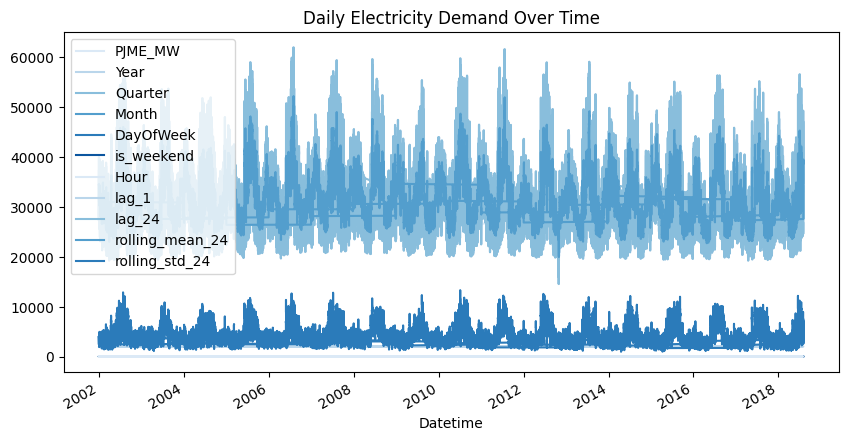

In [24]:
sns.set_palette("Blues")
data.plot(figsize=(10,5),title="Daily Electricity Demand Over Time")
plt.show()

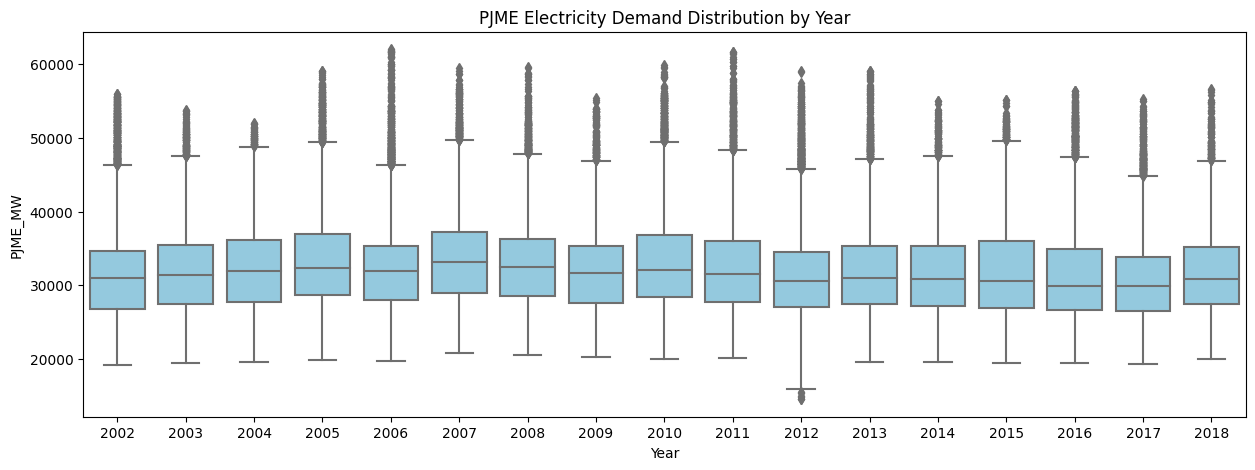

In [25]:
plt.subplots(figsize=(15,5))
sns.boxplot(data=data, x="Year", y="PJME_MW",color="skyblue")
plt.title("PJME Electricity Demand Distribution by Year")
plt.show()

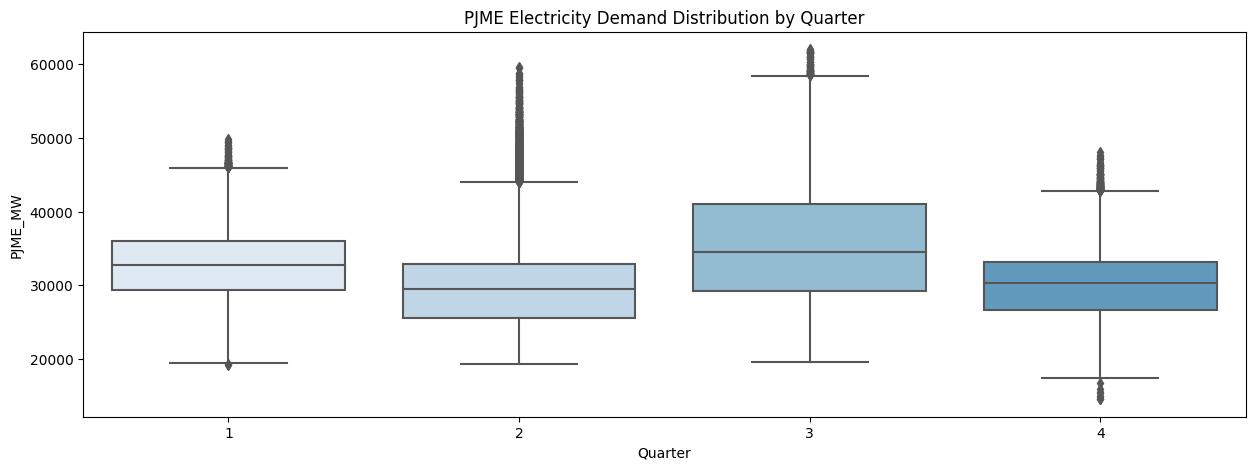

In [26]:
plt.subplots(figsize=(15,5))
sns.boxplot(data=data, x="Quarter", y="PJME_MW")
plt.title("PJME Electricity Demand Distribution by Quarter")
plt.show()

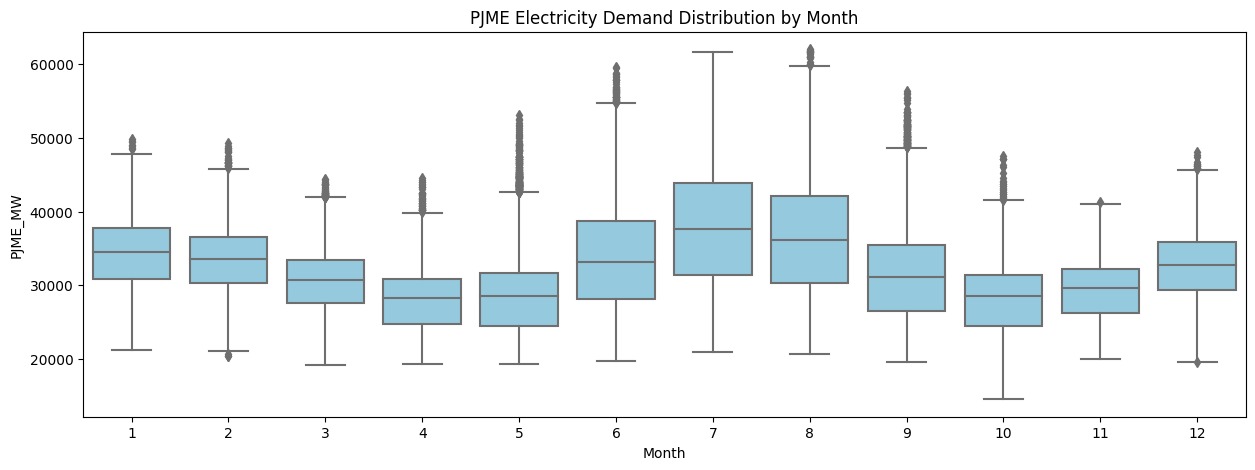

In [27]:
plt.subplots(figsize=(15,5))
sns.boxplot(data=data, x="Month", y="PJME_MW",color="skyblue")
plt.title("PJME Electricity Demand Distribution by Month")
plt.show()

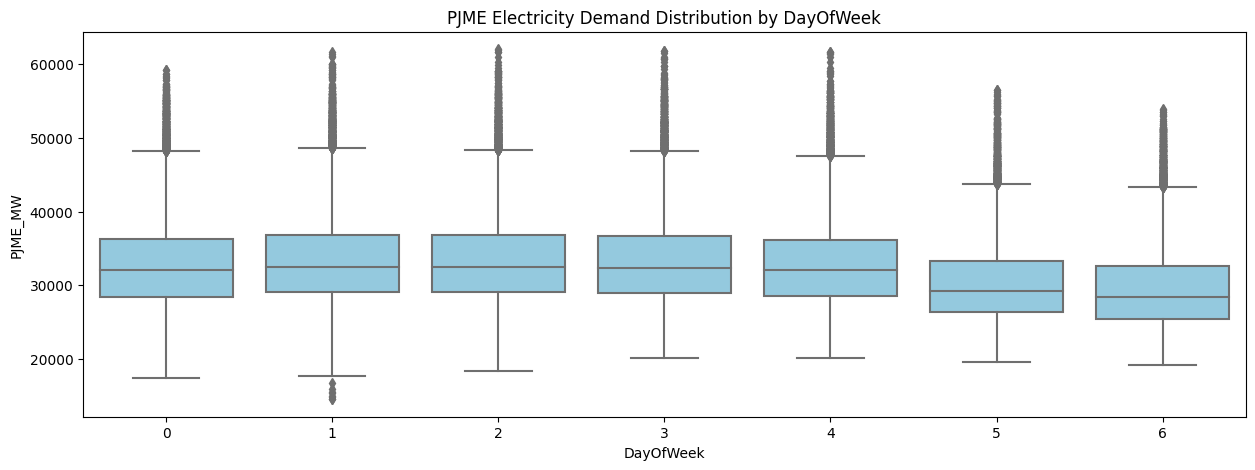

In [28]:
plt.subplots(figsize=(15,5))
sns.boxplot(data=data, x="DayOfWeek", y="PJME_MW",color="skyblue")
plt.title("PJME Electricity Demand Distribution by DayOfWeek")
plt.show()

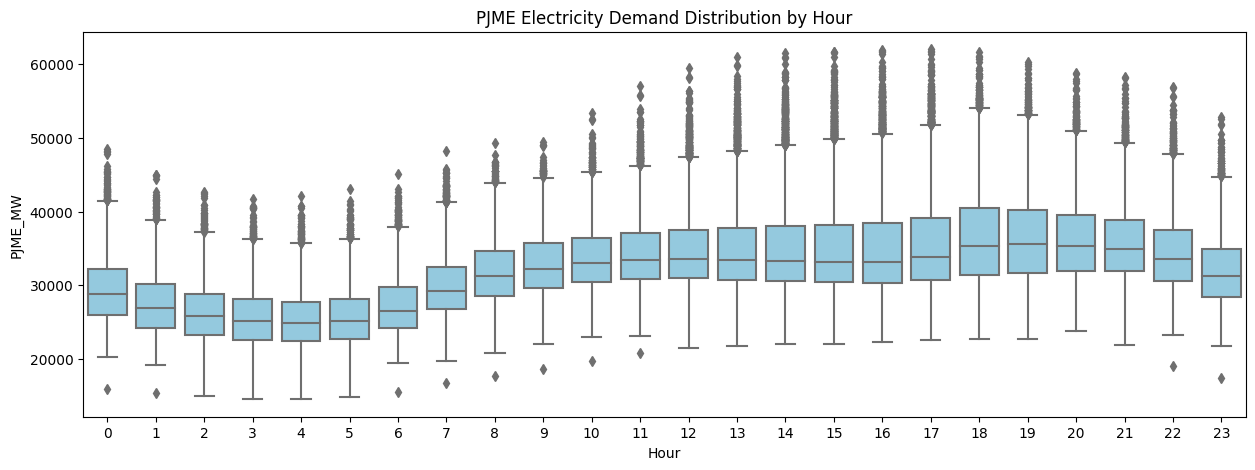

In [29]:
plt.subplots(figsize=(15,5))
sns.boxplot(data=data, x="Hour", y="PJME_MW",color="skyblue")
plt.title("PJME Electricity Demand Distribution by Hour")
plt.show()

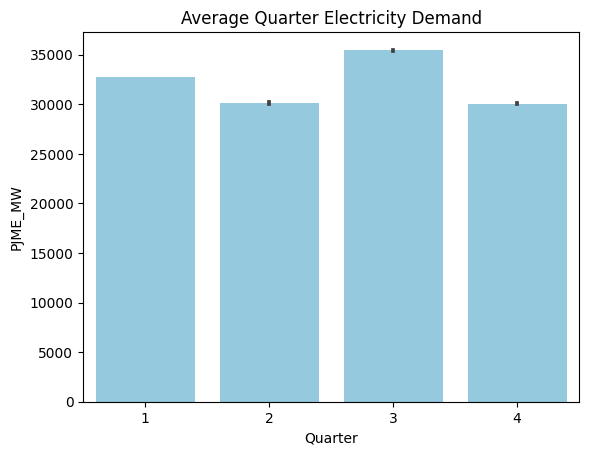

In [30]:
sns.barplot(data=data, x="Quarter", y="PJME_MW", estimator="mean",color="skyblue")
plt.title("Average Quarter Electricity Demand")
plt.show()

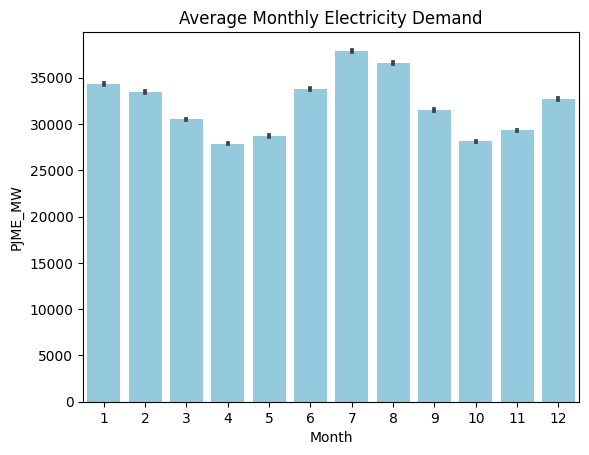

In [31]:
sns.barplot(data=data, x="Month", y="PJME_MW", estimator="mean",color="skyblue")
plt.title("Average Monthly Electricity Demand")
plt.show()

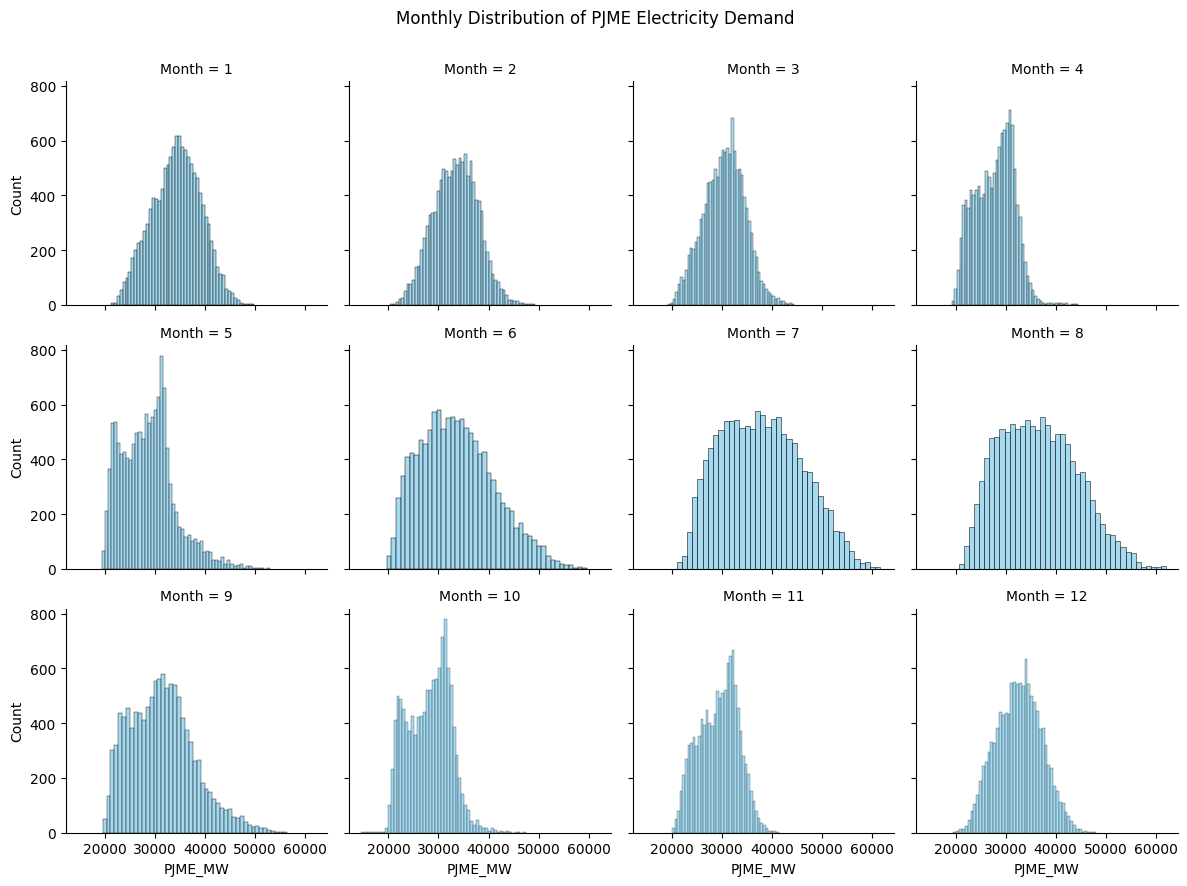

In [32]:
g = sns.FacetGrid(data, col="Month", col_wrap=4, height=3)
g.map(sns.histplot, "PJME_MW",color="skyblue")
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle("Monthly Distribution of PJME Electricity Demand")
plt.show()

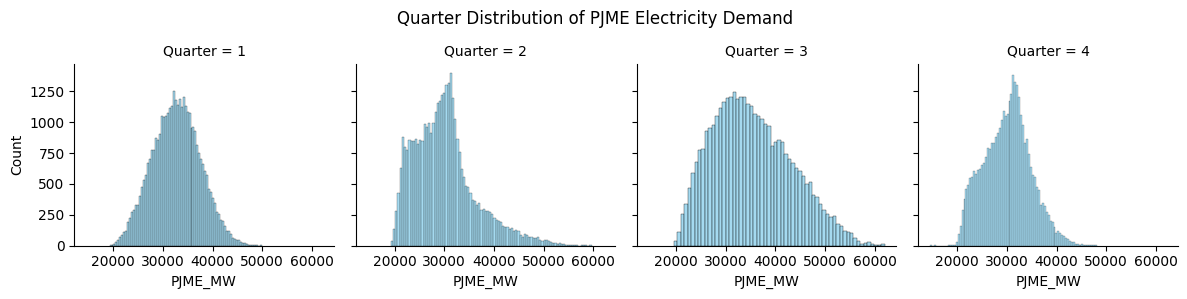

In [33]:
g = sns.FacetGrid(data, col="Quarter", col_wrap=4, height=3)
g.map(sns.histplot, "PJME_MW",color="skyblue")
g.fig.subplots_adjust(top=0.8)
g.fig.suptitle("Quarter Distribution of PJME Electricity Demand")
plt.show()

## Modeling

In [34]:
train_set = data.loc[data.index < "2015-01-01"]
test_set = data.loc[data.index >= "2015-01-01"]

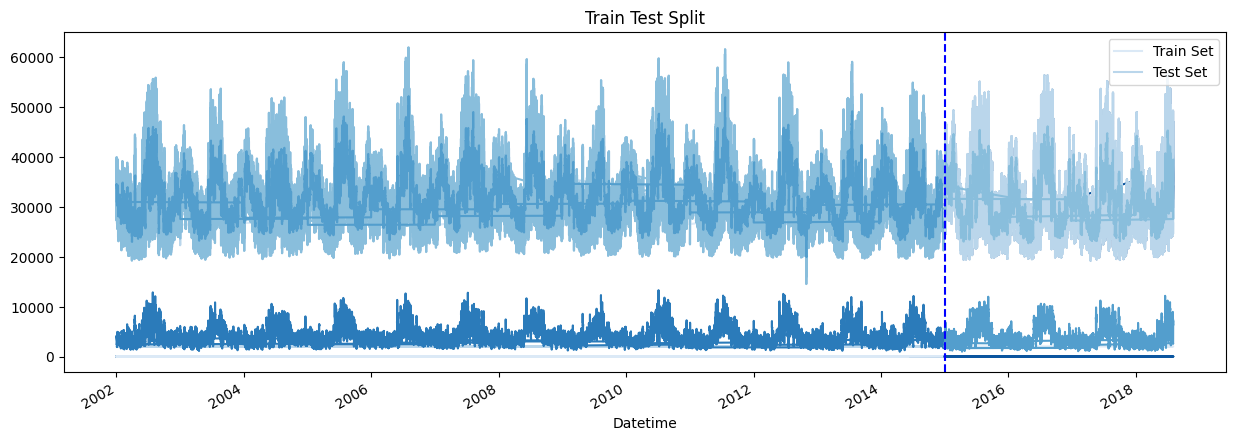

In [35]:
fig,ax=plt.subplots(figsize=(15,5))
train_set.plot(ax=ax)
test_set.plot(ax=ax)
ax.axvline("01-01-2015",color="blue",ls="--")
plt.legend(["Train Set","Test Set"])
plt.title("Train Test Split")
plt.show()

In [36]:
x_train = train_set.drop("PJME_MW", axis=1)
y_train = train_set["PJME_MW"]
x_test = test_set.drop("PJME_MW", axis=1)
y_test = test_set["PJME_MW"]

In [37]:
models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=100, random_state=42),
    "XGBoost": XGBRegressor(n_estimators=100, random_state=42)
}

In [38]:
results = []

for name, model in models.items():
    model.fit(x_train, y_train)
    preds = model.predict(x_test)

    mae = mean_absolute_error(y_test, preds)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    r2 = r2_score(y_test, preds)

    results.append({
        "Model": name,
        "MAE": mae,
        "RMSE": rmse,
        "R²": r2
    })

In [39]:
results_df = pd.DataFrame(results).sort_values(by="RMSE")
print(results_df)

               Model          MAE         RMSE        R²
4            XGBoost   372.056208   596.121802  0.991457
2      Random Forest   367.930933   608.042893  0.991112
3  Gradient Boosting   584.606702   849.838975  0.982638
1   Ridge Regression  1017.408970  1362.826800  0.955352
0  Linear Regression  1017.408974  1362.826806  0.955352


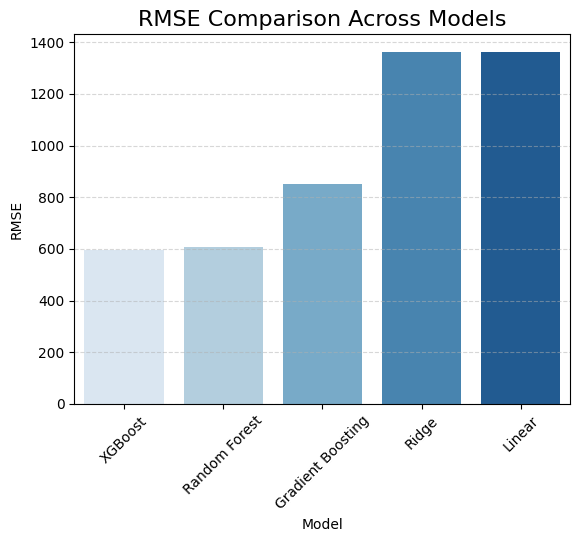

In [40]:
results_df = pd.DataFrame({
    "Model": ["XGBoost", "Random Forest", "Gradient Boosting", "Ridge", "Linear"],
    "RMSE": [596.12, 607.90, 849.84, 1362.83, 1362.83],
    "R²": [0.9915, 0.9911, 0.9826, 0.9554, 0.9554]
})

sns.barplot(data=results_df, x="Model", y="RMSE", palette="Blues")
plt.title("RMSE Comparison Across Models", fontsize=16)
plt.ylabel("RMSE")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

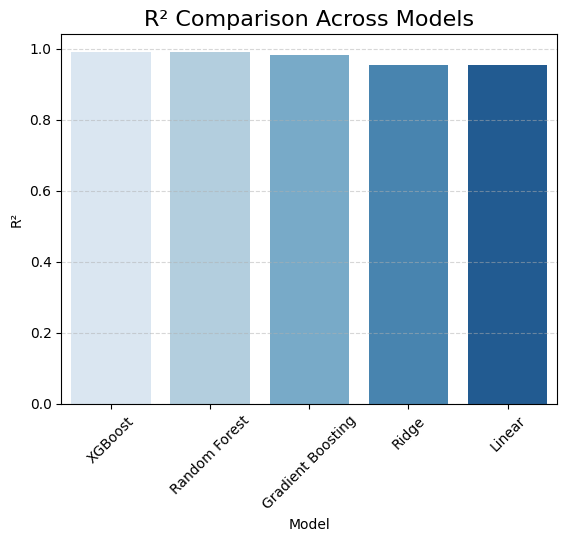

In [41]:
results_df = pd.DataFrame({
    "Model": ["XGBoost", "Random Forest", "Gradient Boosting", "Ridge", "Linear"],
    "RMSE": [596.12, 607.90, 849.84, 1362.83, 1362.83],
    "R²": [0.9915, 0.9911, 0.9826, 0.9554, 0.9554]
})

sns.barplot(data=results_df, x="Model", y="R²", palette="Blues")
plt.title("R² Comparison Across Models", fontsize=16)
plt.ylabel("R²")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()